In [1]:
r"""import pandas as pd

file_path = r"C:\Users\salva\Downloads\ht09_contact_list.dat.gz"
df = pd.read_csv(file_path, compression='gzip', sep='\t')

df_reordered = df.iloc[:, [1, 2, 0]]

output_path = r"C:\Users\salva\OneDrive\Desktop\egohypernet\conference_2.txt"
df_reordered.to_csv(output_path, sep=" ", index=False, header=False)

df_reordered.head()
"""

'import pandas as pd\n\nfile_path = r"C:\\Users\\salva\\Downloads\\ht09_contact_list.dat.gz"\ndf = pd.read_csv(file_path, compression=\'gzip\', sep=\'\\t\')\n\ndf_reordered = df.iloc[:, [1, 2, 0]]\n\noutput_path = r"C:\\Users\\salva\\OneDrive\\Desktop\\egohypernet\\conference_2.txt"\ndf_reordered.to_csv(output_path, sep=" ", index=False, header=False)\n\ndf_reordered.head()\n'

In [2]:
import numpy as np
import dynetx as dn
import networkx as nx
from collections import defaultdict
from itertools import combinations
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import tqdm

import matplotlib.pyplot as plt

# Utils

In [3]:
def get_time_slice_for_half_hour(start_index):
    t_from = temporal_snapshots[start_index]
    t_to = temporal_snapshots[start_index + snapshots_per_half_hour - 1]
    return g.time_slice(t_from=t_from, t_to=t_to)


def slice_net(temporal_snapshots, snapshots_per_half_hour):
    slices = []
    for i in range(0, len(temporal_snapshots) - snapshots_per_half_hour, snapshots_per_half_hour):
        slice_window = get_time_slice_for_half_hour(i)
        slices.append(slice_window)
    return slices


def find_cliques(slices):
    cliques_list = []
    for s in slices:
        cliques = list(nx.find_cliques(s))
        cliques_list.append(cliques)
    return cliques_list


def find_cliques_per_node(slices):
    node_cliques = {}
    for time_index, s in enumerate(slices):
        cliques = list(nx.find_cliques(s))

        for clique in cliques:
            for node in clique:
                if node not in node_cliques:
                    node_cliques[node] = {}  
                if time_index not in node_cliques[node]:
                    node_cliques[node][time_index] = [] 
                node_cliques[node][time_index].append(clique)
    return node_cliques


def mono_freqs(cliques):
    node_frequency = defaultdict(int)
    for clique in cliques:
        for node in clique:
            node_frequency[node] += 1
    sorted_node_frequency = dict(sorted(node_frequency.items(), key=lambda x: x[1], reverse=True))
    return sorted_node_frequency


def high_freqs(cliques, hn):
    high_frequency = defaultdict(int)
    for clique in cliques:
        for high in combinations(clique, hn):
            sorted_high = tuple(sorted(high))
            high_frequency[sorted_high] += 1
    sorted_high_frequency = dict(sorted(high_frequency.items(), key=lambda x: x[1], reverse=True))
    return sorted_high_frequency

# MRENs

In [4]:
def get_mren_for_time_slice(node_cliques, U, time_index):
    mren_hyperedges = []
    for node in U:
        if node in node_cliques and time_index in node_cliques[node]:
            cliques_at_time = node_cliques[node][time_index]
            
            # Aggiungi solo le cliques che contengono almeno un nodo di U
            for clique in cliques_at_time:
                if len(set(clique) & U) > 0:  
                    mren_hyperedges.append(clique)
    return mren_hyperedges


def get_fractured_mren_for_time_slice(node_cliques, U, time_index, alpha):
    mren_hyperedges = []
    for node in U:
        if node in node_cliques and time_index in node_cliques[node]:
            cliques_at_time = node_cliques[node][time_index]
            
            # Aggiungi solo le cliques che contengono almeno una frazione alpha di nodi di U
            for clique in cliques_at_time:
                if len(set(clique) & U) >= alpha * len(U): 
                    mren_hyperedges.append(clique)
    return mren_hyperedges


def get_core_mren_for_time_slice(node_cliques, U, time_index, beta):
    mren_hyperedges = []
    for node in U:
        if node in node_cliques and time_index in node_cliques[node]:
            cliques_at_time = node_cliques[node][time_index]
            
            # Aggiungi solo le cliques che contengono almeno una frazione beta dei nodi nell'iperarchi
            for clique in cliques_at_time:
                if len(set(clique) & U) >= beta * len(clique):
                    mren_hyperedges.append(clique)
    return mren_hyperedges

# Jaccs

In [5]:
def jaccard_similarity(E_U, E_V):
    if len(E_U) == 0 or len(E_V) == 0:
        return 0.0
    
    intersection = set(tuple(sorted(clique)) for clique in E_U) & set(tuple(sorted(clique)) for clique in E_V)
    union = set(tuple(sorted(clique)) for clique in E_U) | set(tuple(sorted(clique)) for clique in E_V)
    
    return len(intersection) / len(union)



def minimum_overlapping_similarity(E_U, E_V):
    if len(E_U) == 0 or len(E_V) == 0:
        return 0.0

    intersection = set(tuple(sorted(clique)) for clique in E_U) & set(tuple(sorted(clique)) for clique in E_V)
    return len(intersection) / min(len(E_U), len(E_V))



def jaccard_index(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0.0

def delta_similarity(E_U, E_V):
    if not E_U and not E_V:
        return 1.0  
    if not E_U or not E_V:
        return 0.0 

    E_U_sets = [set(clique) for clique in E_U]
    E_V_sets = [set(clique) for clique in E_V]

    sum_max_U = sum(max(jaccard_index(e_u, e_v) for e_v in E_V_sets) for e_u in E_U_sets)
    sum_max_V = sum(max(jaccard_index(e_v, e_u) for e_u in E_U_sets) for e_v in E_V_sets)
    
    return (sum_max_U + sum_max_V) / (len(E_U) + len(E_V))

# Main

In [6]:
graph_filename_1 = r"C:\Users\salva\OneDrive\Desktop\egohypernet\primary.txt"
graph_filename_2 = r"C:\Users\salva\OneDrive\Desktop\egohypernet\highschool.txt"
graph_filename_3 = r"C:\Users\salva\OneDrive\Desktop\egohypernet\sfhhh.txt"
graph_filename_4 = r"C:\Users\salva\OneDrive\Desktop\egohypernet\workplace.txt"
#graph_filename_5 = r"C:\Users\salva\OneDrive\Desktop\egohypernet\workplace_2.txt"
graph_filename_6 = r"C:\Users\salva\OneDrive\Desktop\egohypernet\hospital.txt"
graph_filename_7 = r"C:\Users\salva\OneDrive\Desktop\egohypernet\conference_2.txt"

list_snapshots_per_half_hour = [45, 90, 180, 270]
names_snaps = ['15', '30', '60', '90']
names = ['HT Conference', 'SFHH Conference', 'Workplace', 'Hospital Ward', 'Primary School', 'High School']

list_data = [graph_filename_7, graph_filename_3, graph_filename_4, graph_filename_6, graph_filename_1, graph_filename_2]

cumulative_sizes = list(range(10, 100, 10))

# Size and Length (in function of target size U)

In [7]:
"""
for it, graph_filename in tqdm.tqdm(enumerate(list_data)):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()

    plt.figure(figsize=(5, 2.5))
    num_snapshots = len(list_snapshots_per_half_hour)
    colors = cm.Blues(np.linspace(0.4, 1, num_snapshots))

    for snapshots_per_half_hour, snap_name, color in zip(list_snapshots_per_half_hour, names_snaps, colors):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:2500]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    #sizes_egos[len(U)].extend(len(h) for h in mren_t)
                    sizes_egos[len(U)].append(len(mren_t))

        keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items()])
        plt.plot(keys, values, marker='o', linestyle='-', color=color, label=f"{snap_name} min")

    plt.xlabel("|U|")
    plt.ylabel("|E(U)|")
    plt.title(names[it])
    plt.xticks(list(set(keys)))
    plt.grid(alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
"""

'\nfor it, graph_filename in tqdm.tqdm(enumerate(list_data)):\n    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)\n    temporal_snapshots = g.temporal_snapshots_ids()\n\n    plt.figure(figsize=(5, 2.5))\n    num_snapshots = len(list_snapshots_per_half_hour)\n    colors = cm.Blues(np.linspace(0.4, 1, num_snapshots))\n\n    for snapshots_per_half_hour, snap_name, color in zip(list_snapshots_per_half_hour, names_snaps, colors):\n        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)\n        cliques_list = find_cliques(slices)\n        node_cliques = find_cliques_per_node(slices)\n\n        total_freqs = {n: defaultdict(int) for n in range(1, 7)}\n\n        for cliques in cliques_list:\n            for n in range(1, 7):\n                for item, freq in high_freqs(cliques, n).items():\n                    total_freqs[n][item] += freq\n\n        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)

# Multi-root

6it [1:29:07, 891.19s/it] 


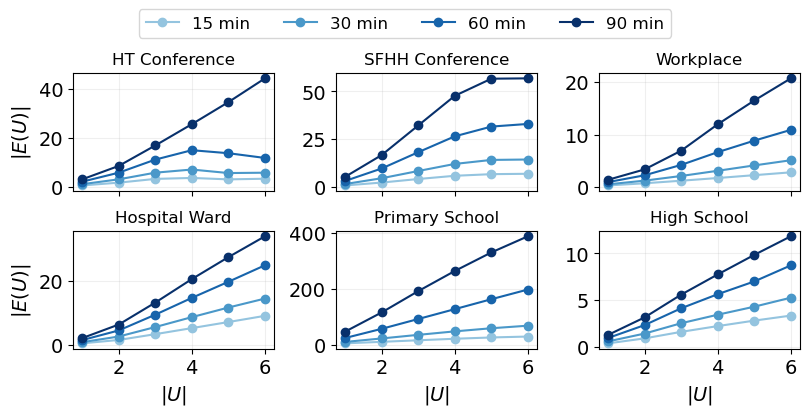

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()
    
    num_snapshots = len(list_snapshots_per_half_hour)
    colors = cm.Blues(np.linspace(0.4, 1, num_snapshots))

    for snapshots_per_half_hour, snap_name, color in zip(list_snapshots_per_half_hour, names_snaps, colors):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    #sizes_egos[len(U)].extend(len(h) for h in mren_t) # DO NOT REMOVE, AVG LENGTH
                    sizes_egos[len(U)].append(len(mren_t)) # |E(U)|

        # only averages
        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)
        
        # with error bars
        #if sizes_egos:
        #    keys, values, errors = zip(*[(k, np.mean(v), np.std(v)) for k, v in sizes_egos.items() if v])
        #    ax.errorbar(keys, values, yerr=errors, marker='o', linestyle='-', label=f"{snap_name} min", color=color, capsize=3)
        
        #if sizes_egos:
        #    keys, values, q1, q3 = zip(*[(k, np.mean(v), np.percentile(v, 25), np.percentile(v, 75)) for k, v in sizes_egos.items() if v])
        #    ax.fill_between(keys, q1, q3, alpha=0.3, color=color)  # Shaded region for IQR
        #    ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)

        
    if it == 0 or it == 3:
        ax.set_ylabel(r"$|\phi_{sim}(U)|$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[it])
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=len(labels), fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()

6it [13:27, 134.51s/it]


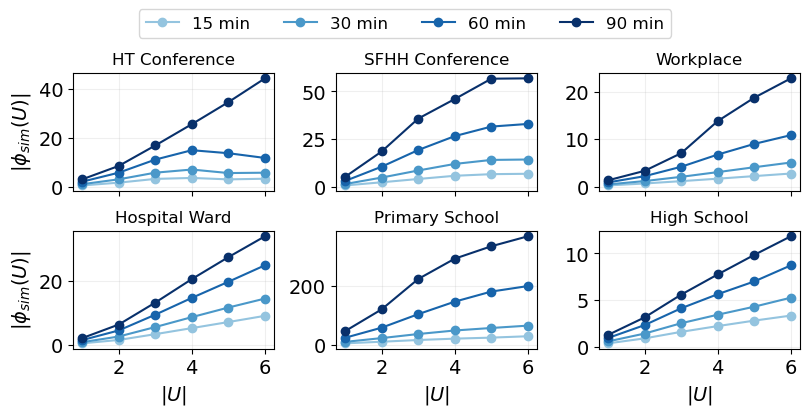

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()
    
    num_snapshots = len(list_snapshots_per_half_hour)
    colors = cm.Blues(np.linspace(0.4, 1, num_snapshots))

    for snapshots_per_half_hour, snap_name, color in zip(list_snapshots_per_half_hour, names_snaps, colors):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:6000]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    #sizes_egos[len(U)].extend(len(h) for h in mren_t) # DO NOT REMOVE, AVG LENGTH
                    sizes_egos[len(U)].append(len(mren_t)) # |E(U)|

        # only averages
        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)
        
        # with error bars
        #if sizes_egos:
        #    keys, values, errors = zip(*[(k, np.mean(v), np.std(v)) for k, v in sizes_egos.items() if v])
        #    ax.errorbar(keys, values, yerr=errors, marker='o', linestyle='-', label=f"{snap_name} min", color=color, capsize=3)
        
        #if sizes_egos:
        #    keys, values, q1, q3 = zip(*[(k, np.mean(v), np.percentile(v, 25), np.percentile(v, 75)) for k, v in sizes_egos.items() if v])
        #    ax.fill_between(keys, q1, q3, alpha=0.3, color=color)  # Shaded region for IQR
        #    ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)

        
    if it == 0 or it == 3:
        ax.set_ylabel(r"$|\phi_{sim}(U)|$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[it])
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=len(labels), fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()

6it [14:44, 147.44s/it]


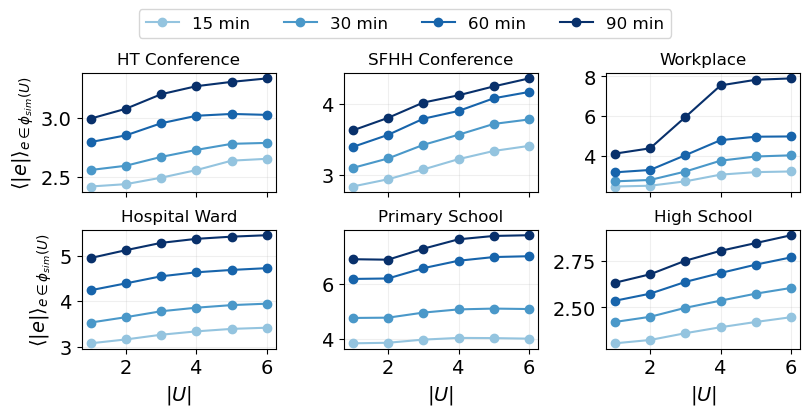

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()
    
    num_snapshots = len(list_snapshots_per_half_hour)
    colors = cm.Blues(np.linspace(0.4, 1, num_snapshots))

    for snapshots_per_half_hour, snap_name, color in zip(list_snapshots_per_half_hour, names_snaps, colors):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:6000]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    sizes_egos[len(U)].extend(len(h) for h in mren_t) # DO NOT REMOVE, AVG LENGTH
                    #sizes_egos[len(U)].append(len(mren_t)) # |E(U)|

        # only averages
        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)
        
        # with error bars
        #if sizes_egos:
        #    keys, values, errors = zip(*[(k, np.mean(v), np.std(v)) for k, v in sizes_egos.items() if v])
        #    ax.errorbar(keys, values, yerr=errors, marker='o', linestyle='-', label=f"{snap_name} min", color=color, capsize=3)
        
        #if sizes_egos:
        #    keys, values, q1, q3 = zip(*[(k, np.mean(v), np.percentile(v, 25), np.percentile(v, 75)) for k, v in sizes_egos.items() if v])
        #    ax.fill_between(keys, q1, q3, alpha=0.3, color=color)  # Shaded region for IQR
        #    ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)

        
    if it == 0 or it == 3:
        ax.set_ylabel(r"$\langle |e| \rangle_{e \in \phi_{sim}(U)}$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[it])
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=len(labels), fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()

# Fractured

6it [05:41, 56.90s/it]


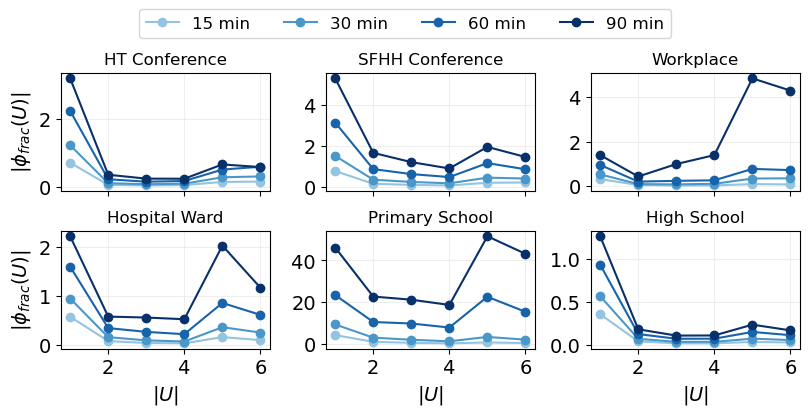

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()
    
    num_snapshots = len(list_snapshots_per_half_hour)
    colors = cm.Blues(np.linspace(0.4, 1, num_snapshots))

    for snapshots_per_half_hour, snap_name, color in zip(list_snapshots_per_half_hour, names_snaps, colors):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:2000]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    #mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    mren_t = get_fractured_mren_for_time_slice(node_cliques, U, t, 0.76)
                    
                    
                    #sizes_egos[len(U)].extend(len(h) for h in mren_t) # DO NOT REMOVE, AVG LENGTH
                    sizes_egos[len(U)].append(len(mren_t)) # |E(U)|

        # only averages
        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)
        
        # with error bars
        #if sizes_egos:
        #    keys, values, errors = zip(*[(k, np.mean(v), np.std(v)) for k, v in sizes_egos.items() if v])
        #    ax.errorbar(keys, values, yerr=errors, marker='o', linestyle='-', label=f"{snap_name} min", color=color, capsize=3)
        
        #if sizes_egos:
        #    keys, values, q1, q3 = zip(*[(k, np.mean(v), np.percentile(v, 25), np.percentile(v, 75)) for k, v in sizes_egos.items() if v])
        #    ax.fill_between(keys, q1, q3, alpha=0.3, color=color)  # Shaded region for IQR
        #    ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)

        
    if it == 0 or it == 3:
        ax.set_ylabel(r"$|\phi_{frac}(U)|$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[it])
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=len(labels), fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()

6it [1:43:19, 1033.30s/it]


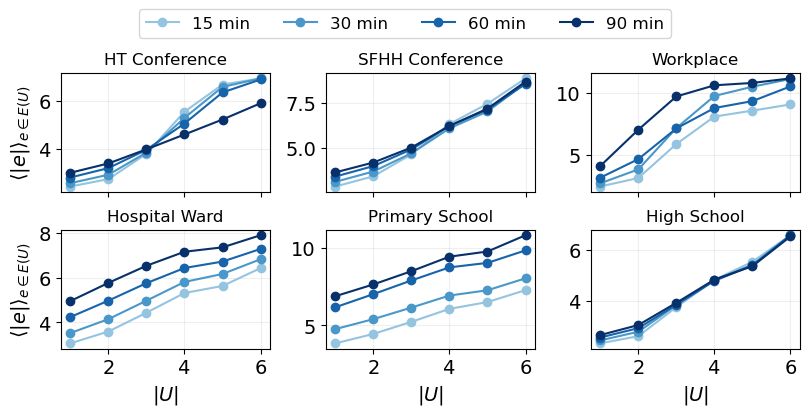

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()
    
    num_snapshots = len(list_snapshots_per_half_hour)
    colors = cm.Blues(np.linspace(0.4, 1, num_snapshots))

    for snapshots_per_half_hour, snap_name, color in zip(list_snapshots_per_half_hour, names_snaps, colors):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_fractured_mren_for_time_slice(node_cliques, U, t, 0.76)
                    
                    sizes_egos[len(U)].extend(len(h) for h in mren_t) # DO NOT REMOVE, AVG LENGTH
                    #sizes_egos[len(U)].append(len(mren_t)) # |E(U)|

        # only averages
        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)
        
        # with error bars
        #if sizes_egos:
        #    keys, values, errors = zip(*[(k, np.mean(v), np.std(v)) for k, v in sizes_egos.items() if v])
        #    ax.errorbar(keys, values, yerr=errors, marker='o', linestyle='-', label=f"{snap_name} min", color=color, capsize=3)
        
        #if sizes_egos:
        #    keys, values, q1, q3 = zip(*[(k, np.mean(v), np.percentile(v, 25), np.percentile(v, 75)) for k, v in sizes_egos.items() if v])
        #    ax.fill_between(keys, q1, q3, alpha=0.3, color=color)  # Shaded region for IQR
        #    ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)

        
    if it == 0 or it == 3:
        ax.set_ylabel(r"$\langle |e| \rangle_{e \in E(U)}$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[it])
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=len(labels), fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()

C:\Users\salva\AppData\Local\Temp\ipykernel_27992\1153891384.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_threshold = cm.get_cmap('Purples')
6it [15:59, 159.83s/it]


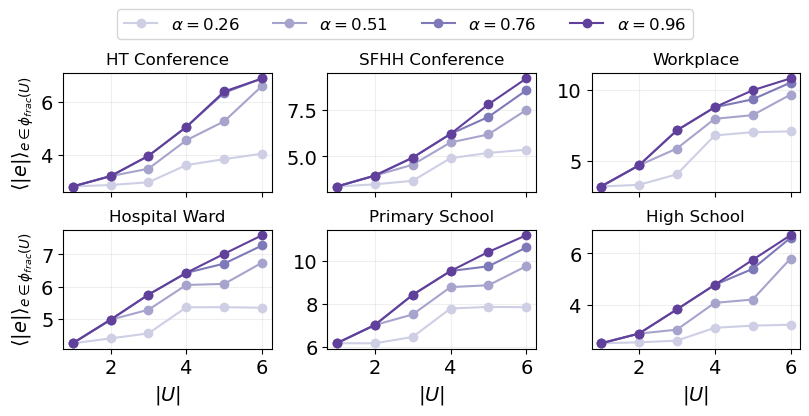

In [42]:
# Impostazioni: snapshot fisso, threshold multipli
list_snapshots_per_half_hour = [180]  # es: 60 minuti
names_snaps = ['60']
thresholds = [0.26, 0.51, 0.76, 0.96]
cmap_threshold = cm.get_cmap('Purples')

fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()

    slices = slice_net(temporal_snapshots, list_snapshots_per_half_hour[0])
    cliques_list = find_cliques(slices)
    node_cliques = find_cliques_per_node(slices)

    total_freqs = {n: defaultdict(int) for n in range(1, 7)}

    for cliques in cliques_list:
        for n in range(1, 7):
            for item, freq in high_freqs(cliques, n).items():
                total_freqs[n][item] += freq

    sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}

    for i, threshold in enumerate(thresholds):
        sizes_egos = defaultdict(list)
        color = cmap_threshold(0.3 + 0.5 * i / (len(thresholds)-1))  # Gradiente nel range [0.4, 0.7]

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:10000]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_fractured_mren_for_time_slice(node_cliques, U, t, threshold)
                    sizes_egos[len(U)].extend(len(h) for h in mren_t)

        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-',
                    label=fr"$\alpha={threshold}$", color=color)

    if it == 0 or it == 3:
        ax.set_ylabel(r"$\langle |e| \rangle_{e \in \phi_{frac}(U)}$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(names[it])
    ax.grid(alpha=0.2)

# Legenda comune
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=len(thresholds), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.show()


# Core

6it [05:46, 57.70s/it]


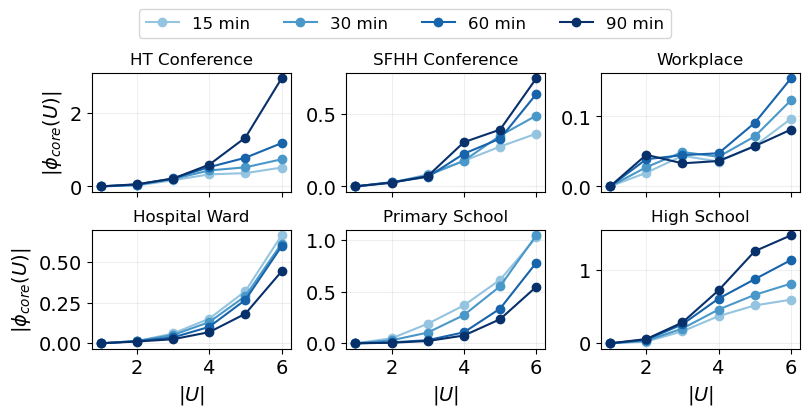

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()
    
    num_snapshots = len(list_snapshots_per_half_hour)
    colors = cm.Blues(np.linspace(0.4, 1, num_snapshots))

    for snapshots_per_half_hour, snap_name, color in zip(list_snapshots_per_half_hour, names_snaps, colors):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:2000]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    #mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    mren_t = get_core_mren_for_time_slice(node_cliques, U, t, 0.76)
                    
                    #sizes_egos[len(U)].extend(len(h) for h in mren_t) # DO NOT REMOVE, AVG LENGTH
                    sizes_egos[len(U)].append(len(mren_t)) # |E(U)|

        # only averages
        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)
        
        # with error bars
        #if sizes_egos:
        #    keys, values, errors = zip(*[(k, np.mean(v), np.std(v)) for k, v in sizes_egos.items() if v])
        #    ax.errorbar(keys, values, yerr=errors, marker='o', linestyle='-', label=f"{snap_name} min", color=color, capsize=3)
        
        #if sizes_egos:
        #    keys, values, q1, q3 = zip(*[(k, np.mean(v), np.percentile(v, 25), np.percentile(v, 75)) for k, v in sizes_egos.items() if v])
        #    ax.fill_between(keys, q1, q3, alpha=0.3, color=color)  # Shaded region for IQR
        #    ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)

        
    if it == 0 or it == 3:
        ax.set_ylabel(r"$|\phi_{core}(U)|$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[it])
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=len(labels), fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()

C:\Users\salva\AppData\Local\Temp\ipykernel_27992\2640841947.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_threshold = cm.get_cmap('Reds')
6it [02:41, 26.94s/it]


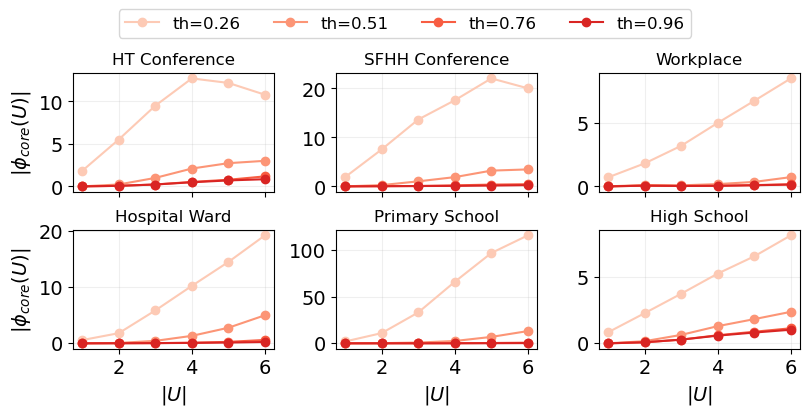

In [27]:
# Impostazioni: snapshot fisso, threshold multipli
list_snapshots_per_half_hour = [180]  # es: 60 minuti
names_snaps = ['60']
thresholds = [0.26, 0.51, 0.76, 0.96]
cmap_threshold = cm.get_cmap('Reds')

fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()

    slices = slice_net(temporal_snapshots, list_snapshots_per_half_hour[0])
    cliques_list = find_cliques(slices)
    node_cliques = find_cliques_per_node(slices)

    total_freqs = {n: defaultdict(int) for n in range(1, 7)}

    for cliques in cliques_list:
        for n in range(1, 7):
            for item, freq in high_freqs(cliques, n).items():
                total_freqs[n][item] += freq

    sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}

    for i, threshold in enumerate(thresholds):
        sizes_egos = defaultdict(list)
        color = cmap_threshold(0.2 + 0.5 * i / (len(thresholds)-1))  # Gradiente nel range [0.4, 0.7]

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:1000]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_core_mren_for_time_slice(node_cliques, U, t, threshold)
                    #sizes_egos[len(U)].extend(len(h) for h in mren_t)
                    sizes_egos[len(U)].append(len(mren_t)) # |E(U)|

        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-',
                    label=f"th={threshold}", color=color)

    if it == 0 or it == 3:
        ax.set_ylabel(r"$|\phi_{core}(U)|$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(names[it])
    ax.grid(alpha=0.2)

# Legenda comune
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=len(thresholds), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.show()


6it [1:36:39, 966.50s/it] 


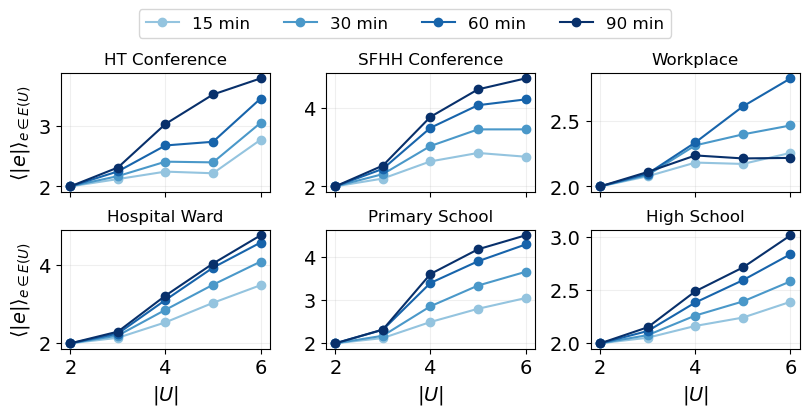

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()
    
    num_snapshots = len(list_snapshots_per_half_hour)
    colors = cm.Blues(np.linspace(0.4, 1, num_snapshots))

    for snapshots_per_half_hour, snap_name, color in zip(list_snapshots_per_half_hour, names_snaps, colors):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    #mren_t = get_fractured_mren_for_time_slice(node_cliques, U, t, 0.51)
                    mren_t = get_core_mren_for_time_slice(node_cliques, U, t, 0.76)
                    
                    sizes_egos[len(U)].extend(len(h) for h in mren_t) # DO NOT REMOVE, AVG LENGTH
                    #sizes_egos[len(U)].append(len(mren_t)) # |E(U)|

        # only averages
        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)
        
        # with error bars
        #if sizes_egos:
        #    keys, values, errors = zip(*[(k, np.mean(v), np.std(v)) for k, v in sizes_egos.items() if v])
        #    ax.errorbar(keys, values, yerr=errors, marker='o', linestyle='-', label=f"{snap_name} min", color=color, capsize=3)
        
        #if sizes_egos:
        #    keys, values, q1, q3 = zip(*[(k, np.mean(v), np.percentile(v, 25), np.percentile(v, 75)) for k, v in sizes_egos.items() if v])
        #    ax.fill_between(keys, q1, q3, alpha=0.3, color=color)  # Shaded region for IQR
        #    ax.plot(keys, values, marker='o', linestyle='-', label=f"{snap_name} min", color=color)

        
    if it == 0 or it == 3:
        ax.set_ylabel(r"$\langle |e| \rangle_{e \in E(U)}$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[it])
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=len(labels), fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()

C:\Users\salva\AppData\Local\Temp\ipykernel_27992\364468834.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_threshold = cm.get_cmap('Purples')
6it [15:28, 154.82s/it]


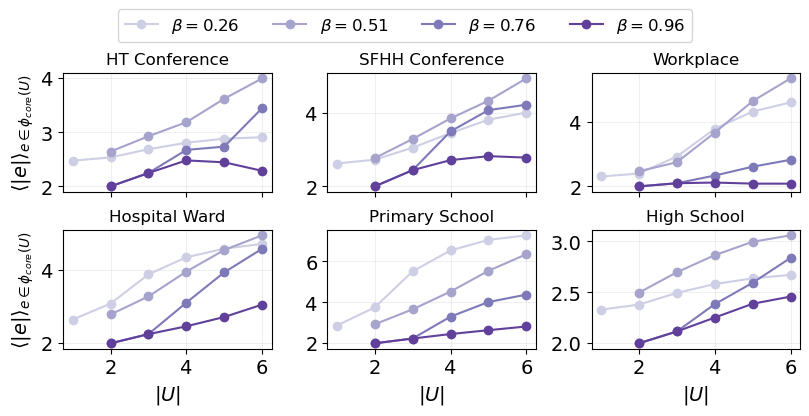

In [41]:
# Impostazioni: snapshot fisso, threshold multipli
list_snapshots_per_half_hour = [180]  # es: 60 minuti
names_snaps = ['60']
thresholds = [0.26, 0.51, 0.76, 0.96]
cmap_threshold = cm.get_cmap('Purples')

fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)
axes = axes.flatten()

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()

    slices = slice_net(temporal_snapshots, list_snapshots_per_half_hour[0])
    cliques_list = find_cliques(slices)
    node_cliques = find_cliques_per_node(slices)

    total_freqs = {n: defaultdict(int) for n in range(1, 7)}

    for cliques in cliques_list:
        for n in range(1, 7):
            for item, freq in high_freqs(cliques, n).items():
                total_freqs[n][item] += freq

    sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}

    for i, threshold in enumerate(thresholds):
        sizes_egos = defaultdict(list)
        color = cmap_threshold(0.3 + 0.5 * i / (len(thresholds)-1))  # Gradiente nel range [0.4, 0.7]

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:10000]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_core_mren_for_time_slice(node_cliques, U, t, threshold)
                    sizes_egos[len(U)].extend(len(h) for h in mren_t)

        if sizes_egos:
            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items() if v])
            ax.plot(keys, values, marker='o', linestyle='-',
                    label=fr"$\beta={threshold}$", color=color)

    if it == 0 or it == 3:
        ax.set_ylabel(r"$\langle |e| \rangle_{e \in \phi_{core}(U)}$", fontsize=14)
    if it >= 3:
        ax.set_xlabel(r"$|U|$", fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(names[it])
    ax.grid(alpha=0.2)

# Legenda comune
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=len(thresholds), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.show()


# Size and Length (fixed aggr, varying t)

In [8]:
list_snapshots_per_half_hour = [180] #[45, 90, 180, 270]
names_snaps = ['60'] #['15', '30', '60', '90']

In [9]:
r"""
for it, graph_filename in enumerate(list_data):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()

    plt.figure(figsize=(5, 2.5))
    num_snapshots = len(list_snapshots_per_half_hour)

    num_lines = 6  # Numero di linee che verranno plottate
    colors = cm.Blues(np.linspace(0.3, 1, num_lines))  # Gradiente di blu

    for snapshots_per_half_hour, snap_name in zip(list_snapshots_per_half_hour, names_snaps):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}

        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    sizes_egos[t].append(len(mren_t))
                    #sizes_egos[t].extend(len(h) for h in mren_t)

            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items()])
            plt.plot(keys, values, linestyle='-', label=f"len(U)={n}", color=colors[n-1])  # Assegna il colore dal gradiente

    plt.xlabel(r"$t$")
    plt.ylabel(r"$|E(U)|$")
    plt.title(names[it])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
"""

'\nfor it, graph_filename in enumerate(list_data):\n    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)\n    temporal_snapshots = g.temporal_snapshots_ids()\n\n    plt.figure(figsize=(5, 2.5))\n    num_snapshots = len(list_snapshots_per_half_hour)\n\n    num_lines = 6  # Numero di linee che verranno plottate\n    colors = cm.Blues(np.linspace(0.3, 1, num_lines))  # Gradiente di blu\n\n    for snapshots_per_half_hour, snap_name in zip(list_snapshots_per_half_hour, names_snaps):\n        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)\n        cliques_list = find_cliques(slices)\n        node_cliques = find_cliques_per_node(slices)\n\n        total_freqs = {n: defaultdict(int) for n in range(1, 7)}\n\n        for cliques in cliques_list:\n            for n in range(1, 7):\n                for item, freq in high_freqs(cliques, n).items():\n                    total_freqs[n][item] += freq\n\n        sorted_freqs = {n: sorted(total_freqs[n].items(), ke

6it [01:38, 16.42s/it]


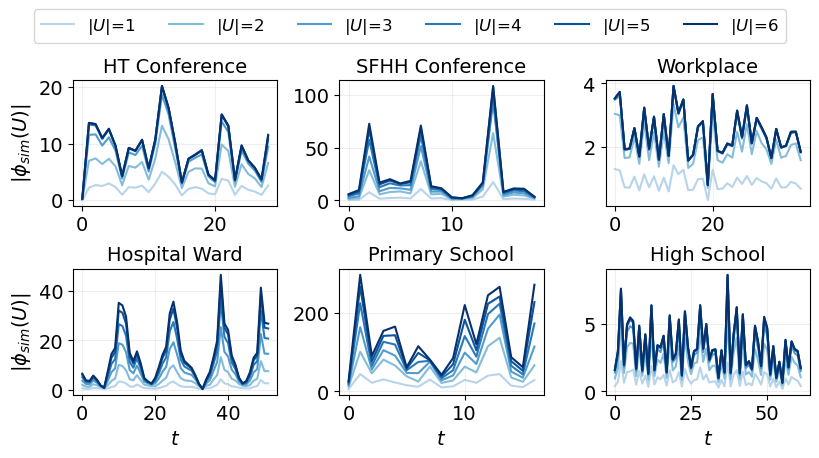

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(8.3, 4.4))  # 2 rows, 3 columns
axes = axes.flat  # Flatten to iterate easily

for idx, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()

    num_lines = 6  
    colors = cm.Blues(np.linspace(0.3, 1, num_lines))  

    for snapshots_per_half_hour, snap_name in zip(list_snapshots_per_half_hour, names_snaps):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:4000]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    sizes_egos[t].append(len(mren_t))

            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items()])
            ax.plot(keys, values, linestyle='-', label=f"$|U|$={n}", color=colors[n-1])

    if idx == 0 or idx == 3:
        ax.set_ylabel(r"$|\phi_{sim}(U)|$", fontsize=14)
    if idx >= 3:
        ax.set_xlabel(r"$t$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[idx], fontsize=14)
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=6, fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()

6it [02:09, 21.61s/it]


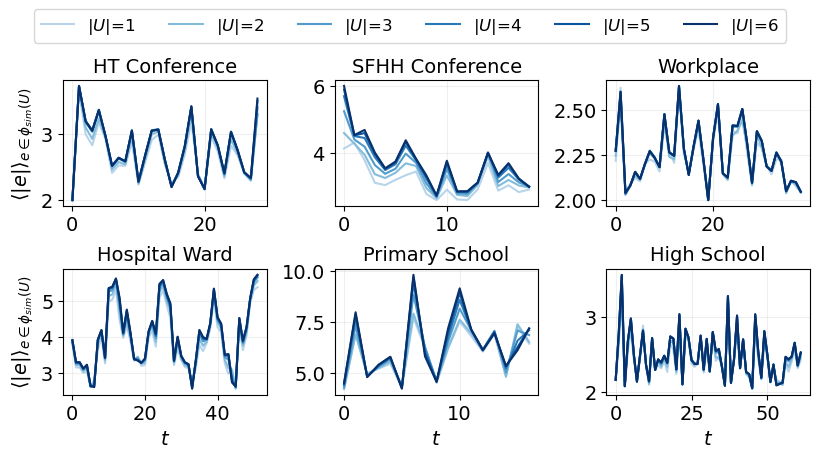

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(8.3, 4.4))  # 2 rows, 3 columns
axes = axes.flat  # Flatten to iterate easily

for idx, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()

    num_lines = 6  
    colors = cm.Blues(np.linspace(0.3, 1, num_lines))  

    for snapshots_per_half_hour, snap_name in zip(list_snapshots_per_half_hour, names_snaps):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sizes_egos = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:4000]:
                U = set(u) if isinstance(u, tuple) else {u}

                for t in range(len(slices)):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    sizes_egos[t].extend(len(h) for h in mren_t)

            keys, values = zip(*[(k, np.mean(v)) for k, v in sizes_egos.items()])
            ax.plot(keys, values, linestyle='-', label=f"$|U|$={n}", color=colors[n-1])

    if idx == 0 or idx == 3:
        ax.set_ylabel(r"$\langle |e| \rangle_{e \in \phi_{sim}(U)}$", fontsize=14)
    if idx >= 3:
        ax.set_xlabel(r"$t$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[idx], fontsize=14)
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=6, fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()

# Cumulative

In [13]:
list_snapshots_per_half_hour = [45, 90, 180, 270]
names_snaps = ['15', '30', '60', '90']

cumulative_sizes = list(range(10, 150, 10))

6it [00:49,  8.17s/it]


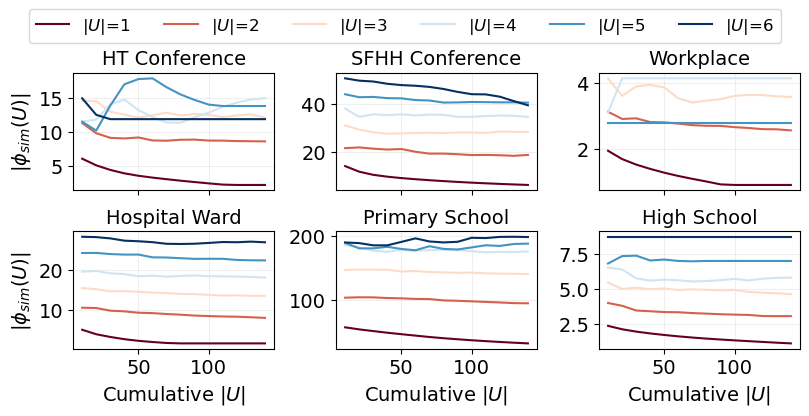

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)  # 2x3 grid
axes = axes.flat  # Flatten for easy iteration

cmap = cm.RdBu
norm = mcolors.Normalize(vmin=1, vmax=6)

handles, labels = [], []  # Store legend items only once

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()
    
    # Select only the 60min aggregation
    if "60" in names_snaps:
        selected_index = names_snaps.index("60")  # Find the index of "60"
    else:
        ax.set_visible(False)  # Hide empty subplot if no 60min data
        continue  # Skip this dataset
    
    snapshots_per_half_hour = list_snapshots_per_half_hour[selected_index]
    
    slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
    cliques_list = find_cliques(slices)
    node_cliques = find_cliques_per_node(slices)

    total_frequencies = {i: defaultdict(int) for i in range(1, 7)}

    for cliques in cliques_list:
        for i in range(1, 7):
            for item, freq in high_freqs(cliques, i).items():
                total_frequencies[i][item] += freq

    sorted_frequencies = {
        i: dict(sorted(total_frequencies[i].items(), key=lambda x: x[1], reverse=True))
        for i in range(1, 7)
    }
    
    sizes_egos = defaultdict(lambda: defaultdict(list))

    for i in range(1, 7):
        elements = list(sorted_frequencies[i].keys())
        for cum_size in cumulative_sizes:
            subset = elements[:cum_size]
            for u in subset:
                U = set([u]) if isinstance(u, int) else set(u)
                for t in range(len(slices)):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    sizes_egos[i][cum_size].append(len(mren_t))

    averages = {
        i: {cum_size: np.mean(vals) if vals else 0 for cum_size, vals in sizes.items()}
        for i, sizes in sizes_egos.items()
    }

    for i, data in averages.items():
        color = cmap(norm(i)) 
        ax.plot(cumulative_sizes, [data[c] for c in cumulative_sizes], 
                        linestyle='-', color=color, label=f"$|U|$={i}")
        
        # Store legend only once
        #if it == 0:
        #    handles.append(line)
        #    labels.append(f"len(U)={i}")

    ax.set_title(names[it], fontsize=14)
    ax.grid(alpha=0.2)

    # Labels only on left and bottom subplots
    row, col = divmod(it, 3)
    if row == 1:
        ax.set_xlabel("Cumulative $|U|$", fontsize=14)
    if col == 0:
        ax.set_ylabel(r"$|\phi_{sim}(U)|$", fontsize=14)
        
    ax.tick_params(axis='both', which='major', labelsize=14)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=6, fontsize=12)  # Horizontal legend with multiple columns
plt.tight_layout()
plt.subplots_adjust(top=0.87)  # Space for title and legend
plt.show()

6it [01:00, 10.08s/it]


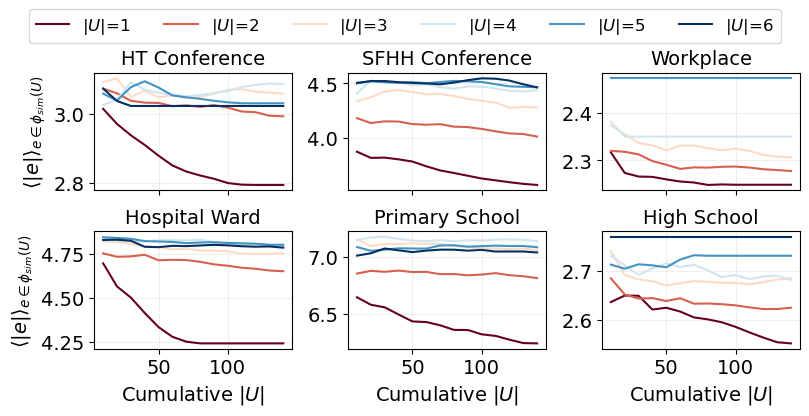

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(8.2, 4), sharex=True)  # 2x3 grid
axes = axes.flat  # Flatten for easy iteration

cmap = cm.RdBu
norm = mcolors.Normalize(vmin=1, vmax=6)

handles, labels = [], []  # Store legend items only once

for it, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()
    
    # Select only the 60min aggregation
    if "60" in names_snaps:
        selected_index = names_snaps.index("60")  # Find the index of "60"
    else:
        ax.set_visible(False)  # Hide empty subplot if no 60min data
        continue  # Skip this dataset
    
    snapshots_per_half_hour = list_snapshots_per_half_hour[selected_index]
    
    slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
    cliques_list = find_cliques(slices)
    node_cliques = find_cliques_per_node(slices)

    total_frequencies = {i: defaultdict(int) for i in range(1, 7)}

    for cliques in cliques_list:
        for i in range(1, 7):
            for item, freq in high_freqs(cliques, i).items():
                total_frequencies[i][item] += freq

    sorted_frequencies = {
        i: dict(sorted(total_frequencies[i].items(), key=lambda x: x[1], reverse=True))
        for i in range(1, 7)
    }
    
    sizes_egos = defaultdict(lambda: defaultdict(list))

    for i in range(1, 7):
        elements = list(sorted_frequencies[i].keys())
        for cum_size in cumulative_sizes:
            subset = elements[:cum_size]
            for u in subset:
                U = set([u]) if isinstance(u, int) else set(u)
                for t in range(len(slices)):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    #lens = [len(h) for h in mren_t]
                    #for l in lens:
                    #    sizes_egos[i][cum_size].append(l)
                    sizes_egos[i][cum_size].extend(len(h) for h in mren_t)

    averages = {
        i: {cum_size: np.mean(vals) if vals else 0 for cum_size, vals in sizes.items()}
        for i, sizes in sizes_egos.items()
    }

    for i, data in averages.items():
        color = cmap(norm(i)) 
        ax.plot(cumulative_sizes, [data[c] for c in cumulative_sizes], 
                        linestyle='-', color=color, label=f"$|U|$={i}")
        
        # Store legend only once
        #if it == 0:
        #    handles.append(line)
        #    labels.append(f"len(U)={i}")

    ax.set_title(names[it], fontsize=14)
    ax.grid(alpha=0.2)

    # Labels only on left and bottom subplots
    row, col = divmod(it, 3)
    if row == 1:
        ax.set_xlabel("Cumulative $|U|$", fontsize=14)
    if col == 0:
        ax.set_ylabel(r"$\langle |e| \rangle_{e \in \phi_{sim}(U)}$", fontsize=14)
        
    ax.tick_params(axis='both', which='major', labelsize=14)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=6, fontsize=12)  # Horizontal legend with multiple columns
plt.tight_layout()
plt.subplots_adjust(top=0.87)  # Space for title and legend
plt.show()

# da rifare: sim values

In [19]:
list_snapshots_per_half_hour = [180] #[45, 90, 180, 270]
names_snaps = ['60'] #['15', '30', '60', '90']

6it [1:42:36, 1026.04s/it]


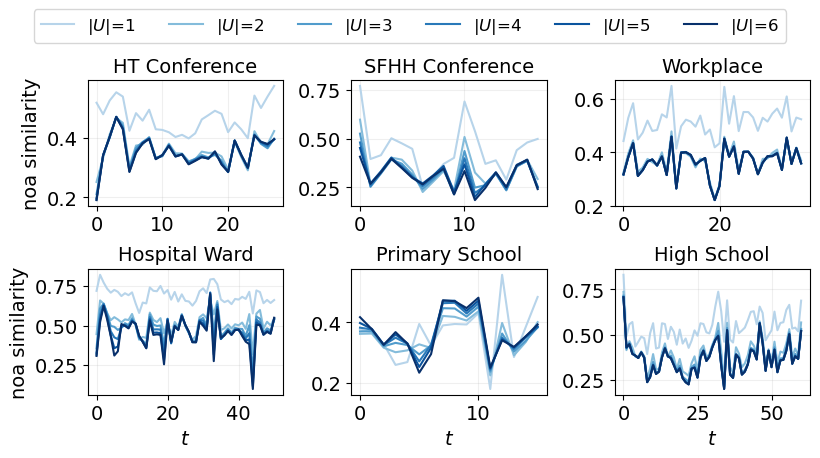

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(8.3, 4.4))  # 2 rows, 3 columns
axes = axes.flat  # Flatten to iterate easily

for idx, (graph_filename, ax) in tqdm.tqdm(enumerate(zip(list_data, axes))):
    g = dn.read_snapshots(graph_filename, nodetype=int, timestamptype=int)
    temporal_snapshots = g.temporal_snapshots_ids()

    num_lines = 6  
    colors = cm.Blues(np.linspace(0.3, 1, num_lines))  

    for snapshots_per_half_hour, snap_name in zip(list_snapshots_per_half_hour, names_snaps):
        slices = slice_net(temporal_snapshots, snapshots_per_half_hour)
        cliques_list = find_cliques(slices)
        node_cliques = find_cliques_per_node(slices)

        total_freqs = {n: defaultdict(int) for n in range(1, 7)}

        for cliques in cliques_list:
            for n in range(1, 7):
                for item, freq in high_freqs(cliques, n).items():
                    total_freqs[n][item] += freq

        sorted_freqs = {n: sorted(total_freqs[n].items(), key=lambda x: x[1], reverse=True) for n in range(1, 7)}
        sim = defaultdict(list)

        for n, sorted_list in sorted_freqs.items():
            for u, _ in sorted_list[:1000]:
                U = set(u) if isinstance(u, tuple) else {u}
                
                for t in range(len(slices)-1):
                    mren_t = get_mren_for_time_slice(node_cliques, U, t)
                    mren_t1 = get_mren_for_time_slice(node_cliques, U, t+1)

                    #jaccard_sim = jaccard_similarity(mren_t, mren_t1)
                    #sim[t].append(jaccard_sim)
                    #min_overlap_sim = minimum_overlapping_similarity(mren_t, mren_t1)
                    #sim[t].append(min_overlap_sim)
                    delta_sim = delta_similarity(mren_t, mren_t1)
                    sim[t].append(delta_sim)

                    #jacs[frozenset(U)].append(jaccard_sim)
                    #jacs_norm[frozenset(U)].append(min_overlap_sim)
                    #overl_jacs[frozenset(U)].append(delta_sim)
                    
            keys, values = zip(*[(k, np.mean(v)) for k, v in sim.items()])
            ax.plot(keys, values, linestyle='-', label=f"$|U|$={n}", color=colors[n-1])

    if idx == 0 or idx == 3:
        ax.set_ylabel(r"noa similarity", fontsize=14)
    if idx >= 3:
        ax.set_xlabel(r"$t$", fontsize=14)
        
    #plt.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_title(names[idx], fontsize=14)
    ax.grid(alpha=0.2)
    #if it == 0: 
    #    ax.legend()
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=6, fontsize=12)  # Horizontal legend with multiple columns

plt.tight_layout()
# Adjust bottom margin to make room for the legend
plt.subplots_adjust(top=0.87)  # Increase this value to add more space for the legend
plt.show()
            